# Stream Learning applied to 3W dataset

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook fits the 3W dataset to models of the River package.

# 2. Imports and Configurations

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
import graphviz
import river
from copy import deepcopy

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly, utils, ensemble, multiclass, datasets, time_series
from river import imblearn

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
river.__version__

'0.14.0'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [5]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['well'] = []
        d['ts'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":
                        d['well'].append(None)
                        d['ts'].append(None)
                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                            if fp.stem.startswith('WELL'):
                                s = fp.stem
                                d['well'][-1] = int(s[5:10])
                                d['ts'][-1] = pd.Timestamp(year=int(s[11:15]), month=int(s[15:17]), day=int(s[17:19]), 
                                                           hour=int(s[19:21]), minute=int(s[21:23]), second=int(s[23:25]))
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, well=None, label=None, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn, well, label)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True, well=None, label=None):

        if label is not None:
            if not isinstance(label, list):
                label = [label]
            return self.df[self.df.label.isin(label)].drop(columns=['origin', 'well']).reset_index(drop=True)
            
        if well is not None:
            return self.df[self.df['well']==well].drop(columns=['origin', 'well']).reset_index(drop=True)
        
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin', 'well']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [6]:
if pathlib.Path('dset_tfm1.pkl').exists():
  with open('dset_tfm1.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_tfm1.pkl', 'wb') as f:
      pickle.dump(dset, f)

Subset for labels 0 (Normal conditions) and 2 (SPURIOUS CLOSURE OF DHSV).

In [7]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]]

train_df, test_df, val_df = dset.split(label=[0, 1], test_size=0.5, val_size=0.1, sample_n=None)

Instances Train: 326  Test: 363  Validation: 37


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.  

            TYPE OF UNDESIRABLE EVENT       WINDOW SIZE   
		
            1 - ABRUPT INCREASE OF BSW       12h 
            2 – SPURIOUS CLOSURE OF DHSV     5min–20min 
            3 – SEVERE SLUGGING         	 5h 
            4 – FLOW INSTABILITY             15min 
            5 – RAPID PRODUCTIVITY LOSS 	 12h 
            6 – QUICK RESTRICTION IN PCK     15min 
            7 – SCALING IN PCK               72h 
            8 – HYDRATE IN PRODUCTION LINE   30min–5h 


In [8]:
class CustomGen():
    '''instance generator for the 3W files in dset'''
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False, min_std=None):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        self.min_std = min_std
        return
    
    def todataframe(self):
        ds_list = []
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            ds['ifile'] = ifile
            
            ds_list.append(ds)
        return pd.concat(ds_list, ignore_index=True)
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        xm = df[self.flist].mean()
        sm = df[self.flist].std()
        if self.min_std is not None:
            sm = pd.concat([sm, pd.Series(self.min_std)]).groupby(level=0).max()[sm.index]
        return (df[self.flist]-xm)/sm

    def plot(self, ifiles):
        
        if isinstance(ifiles, list):
            n_files = len(ifiles)
        else:
            ifiles = [ifiles]
            n_files = 1
        
        fig, axs = plt.subplots(nrows=len(self.flist)+1, ncols=n_files, figsize=(10, 12), sharex='col')
        axs = axs.flatten()

        dss = []
        supt = ''
        for i_col, i_f in enumerate(ifiles):
        
            dss.append(pd.read_csv(self.dset['path'][i_f], parse_dates=["timestamp"]))
            #ds = ds.drop_duplicates(subset='timestamp', keep="last").sort_values(by=['timestamp']).reset_index(drop=True)
            if np.any(dss[i_col][self.target].isna()):
                ds[i_col][self.target] = ds[i_col][self.target].fillna(method='ffill')
            
            supt += str(self.dset['path'][i_f])
            if i_col != n_files-1:
                supt += '\n'
            fig.suptitle(supt)

            for i, vs in enumerate(self.flist):
                axs[i*n_files+i_col].plot(dss[i_col].timestamp[::60], dss[i_col][vs][::60])
                if i_col == 0:
                    axs[i*n_files+i_col].set_ylabel(vs)
        
            id = np.argsort(dss[i_col][self.target])
            t = [dss[i_col].timestamp[i] for i in id][::60]
            y = [str(dss[i_col][self.target][i]) for i in id][::60]
        
            axs[(i+1)*n_files+i_col].scatter(t, y, marker='.')
        
            axs[(i+1)*n_files+i_col].xaxis.set_tick_params(rotation=45)
            
            if i_col == 0:
                axs[(i+1)*n_files+i_col].set_ylabel(self.target)
        
            axs[(i+1)*n_files+i_col].set_xlabel('Date')
            
        
        for ax in axs.flatten():
            ax.grid(visible=True)

        return fig  


In [9]:
gen = CustomGen(train_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2018-10-06 04:44:00 {'P-PDG': -1.4214479188047917, 'P-TPT': -1.060569650881211, 'T-TPT': -1.7726256853978135, 'P-MON-CKP': 1.3166162926942242, 'T-JUS-CKP': -1.7891812067747672, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2018-10-06 04:45:00 {'P-PDG': -1.4215037461868347, 'P-TPT': -1.0603490065388428, 'T-TPT': -1.7719855655879413, 'P-MON-CKP': 1.3164430549028805, 'T-JUS-CKP': -1.7884802980007541, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2018-10-06 04:46:00 {'P-PDG': -1.421519045036721, 'P-TPT': -1.0603879136618624, 'T-TPT': -1.7709611593568235, 'P-MON-CKP': 1.3162866596746532, 'T-JUS-CKP': -1.7871021263630174, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2018-10-06 04:47:00 {'P-PDG': -1.421577824828389, 'P-TPT': -1.060493884378498, 'T-TPT': -1.769953647783447, 'P-MON-CKP': 1.3161831982159322, 'T-JUS-CKP': -1.785732203298652, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0


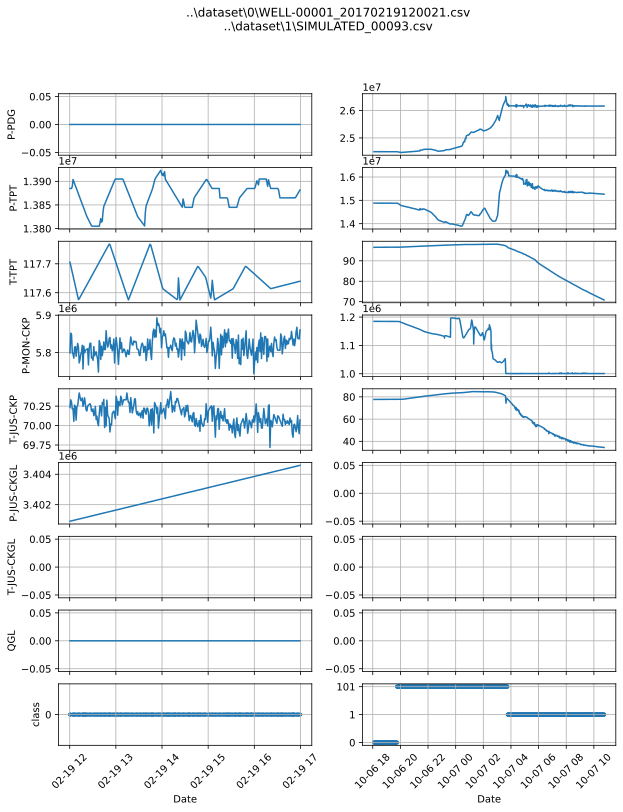

In [10]:
gen.plot([0,2])
plt.savefig('plot.jpg')

### Ajuste del Modelo  

Fit the subset to River models:
- A time window of 15min is used for calculating the rolling statistics:  
     mean, std, min, max  
  of every feature
- The standard scaler and the rolling statistics are reinitialized every new time series
- The fit starts after a warming period (equal to the rolling window size)

In [11]:
def fit_model(data_df, flist, target, window_size: int, model0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)

            if not EvalB:
                model.learn_one(xd, y)

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)

    print('\n', report)
    print('\n', report0)
    if dfB:
        return ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return ys, y_preds, accuracies, report, ifiles, model

In [14]:
%%time

#model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
#model =  multiclass.OneVsOneClassifier(tree.HoeffdingTreeClassifier(delta=1.E-4))
#model =  multiclass.OneVsOneClassifier(linear_model.PAClassifier(C=1.0, mode=1))
#model = multiclass.OneVsOneClassifier(linear_model.ALMAClassifier())
model = imblearn.RandomOverSampler((tree.HoeffdingTreeClassifier(delta=1.E-4)),
        desired_dist={0: 0.4, 101: 0.3, 1: 0.3}, seed=200560)


flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
window_size = 15
epochs = 10

reports = epochs*[0]
reportsv = epochs*[0]
models = []
for epoch in range(epochs):
    print('\nepoch: {}\n'.format(epoch+1))
    ys, y_preds, accuracies, reports[epoch], ifiles, model, df = fit_model(train_df, flist, 'class', window_size,
                                                                  model, dfB=True, EvalB=False)
    models.append(model)
    yse, y_predse, accuraciese, reportsv[epoch], _, _, v_df = fit_model(val_df, flist, 'class', window_size, 
                                                                model, dfB=True, EvalB=True)    


epoch: 1

files learned  326 / 326
 BalancedAccuracy: 93.89%

            Precision   Recall   F1       Support  
                                                  
     0.0      98.63%   96.79%   97.70%     75634  
     1.0      89.22%   92.12%   90.65%     23179  
   101.0      91.11%   92.74%   91.92%     36739  
                                                  
   Macro      92.99%   93.89%   93.42%            
   Micro      94.89%   94.89%   94.89%            
Weighted      94.98%   94.89%   94.93%            

                 94.89% accuracy                  
files learned  37 / 37
 BalancedAccuracy: 75.57%

            Precision   Recall   F1       Support  
                                                  
     0.0      93.25%   98.59%   95.85%      8462  
     1.0      87.22%   31.87%   46.68%      2548  
   101.0      77.72%   96.23%   85.99%      4752  
                                                  
   Macro      86.06%   75.57%   76.17%            
   Micro      87.

files learned  37 / 37
 BalancedAccuracy: 87.25%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.01%   99.33%   99.17%      8462  
     1.0      74.42%   78.22%   76.27%      2548  
   101.0      87.07%   84.20%   85.61%      4752  
                                                  
   Macro      86.83%   87.25%   87.02%            
   Micro      91.35%   91.35%   91.35%            
Weighted      91.44%   91.35%   91.38%            

                 91.35% accuracy                  

epoch: 9

files learned  326 / 326
 BalancedAccuracy: 90.92%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.36%   99.25%   99.30%     75634  
     1.0      76.63%   91.83%   83.54%     23179  
   101.0      93.12%   81.69%   87.03%     36739  
                                                  
   Macro      89.70%   90.92%   89.96%            
   Micro      93.

In [15]:
print('epoch    Train       Val')
for i, (x, y) in enumerate(zip(reports, reportsv)):
    print('  {:2d}    {:6.2f}%    {:6.2f}%'.format(i, x.get()*100, y.get()*100))

epoch    Train       Val
   0     93.89%     75.57%
   1     93.61%     36.67%
   2     93.06%     36.84%
   3     90.45%     80.72%
   4     90.17%     80.44%
   5     89.98%     87.85%
   6     90.21%     87.48%
   7     90.42%     87.25%
   8     90.92%     88.03%
   9     91.19%     88.02%


In [16]:
model_fitted = deepcopy(models[8])
with open('model_1.pkl', 'wb') as f:
  pickle.dump(model_fitted, f)

In [138]:
if pathlib.Path('model_1.pkl').exists():
  with open('model_1.pkl', 'rb') as f:
    model_fitted = pickle.load(f)

In [17]:
model_fitted.classifier.height

56

In [18]:
yse, y_predse, accuraciese, _, _, _, v_df = fit_model(val_df, flist, 'class', window_size, 
                                                            model_fitted, dfB=True, EvalB=True)    

files learned  37 / 37
 BalancedAccuracy: 88.03%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.22%   99.34%   99.28%      8462  
     1.0      76.34%   78.89%   77.59%      2548  
   101.0      87.63%   85.88%   86.75%      4752  
                                                  
   Macro      87.73%   88.03%   87.87%            
   Micro      91.97%   91.97%   91.97%            
Weighted      92.03%   91.97%   92.00%            

                 91.97% accuracy                  


In [19]:
from sklearn.metrics import classification_report
#np.unique(y_preds, return_counts=True)
print(classification_report(yse, y_predse))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      8462
         1.0       0.76      0.79      0.78      2548
       101.0       0.88      0.86      0.87      4752

    accuracy                           0.92     15762
   macro avg       0.88      0.88      0.88     15762
weighted avg       0.92      0.92      0.92     15762



In [20]:
%%time

# Variable Importance

from sklearn.ensemble import RandomForestClassifier

f_list = []
for f in df.columns:
    n = sum(df[f].isnull())
    print(f, n)
    if n == 0:
        f_list.append(f)
f_list = f_list[:-1]

forest = RandomForestClassifier(random_state=200560)
forest.fit(df[f_list], df['class'])
print('mean accuracy Random Forest: ', forest.score(df[f_list], df['class']))
varImp = {'var': f_list, 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp).sort_values(['varImp'], ascending=False)
print(varImp)

varImp = {'var': [x[0] for x in [x.split('_') for x in f_list]], 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp)
varImp = varImp.groupby('var').sum().sort_values(['varImp'], ascending=False).reset_index()
varImp

P-PDG_rmean 0
P-PDG_rSEM 0
P-PDG_rMax 0
P-PDG_rMin 0
P-TPT_rmean 0
P-TPT_rSEM 0
P-TPT_rMax 0
P-TPT_rMin 0
T-TPT_rmean 0
T-TPT_rSEM 0
T-TPT_rMax 0
T-TPT_rMin 0
P-MON-CKP_rmean 6763
P-MON-CKP_rSEM 6763
P-MON-CKP_rMax 6763
P-MON-CKP_rMin 6763
T-JUS-CKP_rmean 9033
T-JUS-CKP_rSEM 9033
T-JUS-CKP_rMax 9033
T-JUS-CKP_rMin 9033
P-JUS-CKGL_rmean 82755
P-JUS-CKGL_rSEM 82755
P-JUS-CKGL_rMax 82755
P-JUS-CKGL_rMin 82755
QGL_rmean 82649
QGL_rSEM 82649
QGL_rMax 82649
QGL_rMin 82649
class 0
mean accuracy Random Forest:  1.0
            var    varImp
3    P-PDG_rMin  0.235660
0   P-PDG_rmean  0.174716
2    P-PDG_rMax  0.129242
8   T-TPT_rmean  0.095605
11   T-TPT_rMin  0.083776
1    P-PDG_rSEM  0.075351
10   T-TPT_rMax  0.049409
7    P-TPT_rMin  0.039017
6    P-TPT_rMax  0.035462
4   P-TPT_rmean  0.032608
9    T-TPT_rSEM  0.029212
5    P-TPT_rSEM  0.019943
CPU times: total: 25.4 s
Wall time: 27.4 s


,var,varImp
0,P-PDG,0.614969
1,T-TPT,0.258002
2,P-TPT,0.127030


In [21]:
# Random Forest on validation set
print(classification_report(v_df['class'], forest.predict((v_df[f_list]))))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8462
         1.0       0.93      0.85      0.89      2548
       101.0       0.92      0.96      0.94      4752

    accuracy                           0.96     15762
   macro avg       0.95      0.94      0.94     15762
weighted avg       0.96      0.96      0.96     15762



In [41]:
def plot_acc(accuracies, accuraciesD, supt, subt):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(accuracies, label='Predict/Fit')
    plt.plot(accuraciesD, label='Evaluated')
    plt.legend(loc="lower right")
    plt.title(supt + '\n' + subt)
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m-0.05, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1-0.05, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
    plt.grid()
    plt.show()
    return

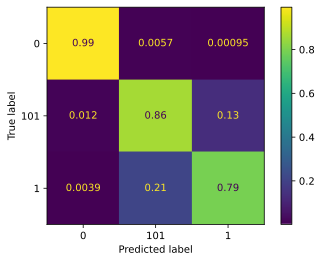

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay(confusion_matrix(yse, y_predse, labels=[0, 101, 1], normalize='true'), 
                       display_labels=[0, 101, 1]).plot()

## Drift test

In [24]:
class drift_reg:
    def __init__(self):
        self.d = {'i': [], 'n': [], 'ifile': [], 'label': [], 'y': [], 'path': [], 'warn': [], 
                  'change': [], 'origin': [], 'well': []}
        return
    def append(self, i, n, ifile, label, y, path, warn, change):
        self.d['i'].append(i)
        self.d['n'].append(n)
        self.d['ifile'].append(ifile)
        self.d['label'].append(label)
        self.d['y'].append(int(y))
        self.d['path'].append(path)
        self.d['warn'].append(warn)
        self.d['change'].append(change)
        self.d['well'].append(None)
        if (path.stem.startswith("SIMULATED")):
            self.d['origin'].append('S')
        elif path.stem.startswith("DRAWN"):
            self.d['origin'].append('D')
        else:
            self.d['origin'].append('R')
            if path.stem.startswith('WELL'):
                self.d['well'][-1] = int(path.stem[5:10])


        return
    def to_df(self):
        return pd.DataFrame(self.d)

In [30]:
def fit_modelD(data_df, flist, target, window_size: int, model0, dr, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
            print_warning = True
            drd = drift.EDDM(warm_start=30, alpha=0.7, beta=0.6)
            n = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)
            _ = drd.update(y != y_pred)
            warn = change = False
            if drd.warning_detected and print_warning:
                warn = True
                print(f"\nWarning detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = False
                dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change)
            if drd.drift_detected:
                change = True
                print(f"\nChange detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = True
                dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change)
            n += 1

            if not EvalB:
                model.learn_one(xd, y)

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)

    print('\n', report)
    print('\n', report0)
    if dfB:
        return ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return ys, y_preds, accuracies, report, ifiles, model

In [31]:
dr = drift_reg()
yse, y_predse, accuraciese, report, ifiles, _, t_df = fit_modelD(test_df, flist, 'class', window_size, 
                                                            model_fitted, dr, dfB=True, EvalB=True)    

files learned  1 / 363
Change detected at index 802 788, ifile 0, label 1 101.0 SIMULATED_00103
files learned  8 / 363
Change detected at index 3397 288, ifile 7, label 1 101.0 SIMULATED_00086

Warning detected at index 3501 392, ifile 7, label 1 101.0 SIMULATED_00086
files learned  11 / 363
Change detected at index 5261 554, ifile 10, label 1 101.0 SIMULATED_00090
files learned  14 / 363
Warning detected at index 6431 123, ifile 13, label 1 101.0 WELL-00001_20140124213136

Change detected at index 6455 147, ifile 13, label 1 101.0 WELL-00001_20140124213136
files learned  37 / 363
Change detected at index 14049 1075, ifile 36, label 1 1.0 SIMULATED_00009
files learned  61 / 363
Change detected at index 20341 146, ifile 60, label 1 0.0 DRAWN_00004
files learned  62 / 363
Change detected at index 21422 506, ifile 61, label 1 101.0 SIMULATED_00097
files learned  65 / 363
Change detected at index 23832 1074, ifile 64, label 1 1.0 SIMULATED_00017
files learned  81 / 363
Warning detected at 


Warning detected at index 131264 829, ifile 300, label 1 101.0 SIMULATED_00106

Change detected at index 131379 944, ifile 300, label 1 101.0 SIMULATED_00106
files learned  303 / 363
Change detected at index 133094 879, ifile 302, label 1 101.0 SIMULATED_00031
files learned  314 / 363
Change detected at index 136900 55, ifile 313, label 1 0.0 DRAWN_00006

Warning detected at index 136951 106, ifile 313, label 1 0.0 DRAWN_00006

Change detected at index 136952 107, ifile 313, label 1 0.0 DRAWN_00006
files learned  325 / 363
Change detected at index 141974 705, ifile 324, label 1 101.0 SIMULATED_00110
files learned  330 / 363
Change detected at index 144016 81, ifile 329, label 0 0.0 WELL-00008_20170702050135
files learned  338 / 363
Change detected at index 146284 263, ifile 337, label 1 101.0 SIMULATED_00023
files learned  341 / 363
Change detected at index 148083 699, ifile 340, label 1 1.0 SIMULATED_00087
files learned  344 / 363
Change detected at index 149522 666, ifile 343, label

In [33]:
# train on complete files detected with drift

res = dr.to_df()

model_fittedD = deepcopy(model_fitted)

drift_files = res.ifile.unique()

t_df['ifile'] = ifiles

for i in t_df[t_df.ifile.isin(drift_files)].index:
    model_fittedD.learn_one(t_df.drop(['class', 'ifile'], axis=1).iloc[i].to_dict(), t_df.iloc[i]['class'])

In [ ]:
#train in the time windows where drift is detected

res = dr.to_df()

model_fittedD = deepcopy(model_fitted)
epochs = 1
last_ifile = -1
for i, rec in res.iterrows():
    print(i, rec['ifile'], rec['i'], rec['n'], rec['warn'], rec['change'])
    if rec['ifile'] != last_ifile:
        ini = -1
        fin = -1
        last_ifile = rec['ifile']
    if rec['warn']:
        ini = rec['i'] - min(30, rec['n'])
    elif rec['change']:
        if ini >= 0:
            fin = rec['i']
        else:
            ini = rec['i'] - min(30, rec['n'])
            fin = rec['i']
    if ini * fin >= 0:
        print('***', ini, fin)
        for epoch in range(epochs):
            for j in range(ini, fin+1):
                model_fittedD.learn_one(t_df.drop('class', axis=1).iloc[j].to_dict(), t_df.iloc[j]['class'])
            

In [34]:
drD = drift_reg()
yseD, y_predseD, accuracieseD, reportD, _, _ = fit_modelD(test_df, flist, 'class', window_size, 
                                                            model_fittedD, drD, dfB=False, EvalB=True)    

files learned  1 / 363
Change detected at index 802 788, ifile 0, label 1 101.0 SIMULATED_00103
files learned  5 / 363
Change detected at index 2657 266, ifile 4, label 0 0.0 WELL-00002_20170309020218
files learned  6 / 363
Change detected at index 2766 76, ifile 5, label 0 0.0 WELL-00001_20170218110218

Change detected at index 2826 136, ifile 5, label 0 0.0 WELL-00001_20170218110218

Change detected at index 2903 213, ifile 5, label 0 0.0 WELL-00001_20170218110218
files learned  8 / 363
Change detected at index 3395 286, ifile 7, label 1 101.0 SIMULATED_00086

Warning detected at index 3506 397, ifile 7, label 1 101.0 SIMULATED_00086
files learned  11 / 363
Change detected at index 5261 554, ifile 10, label 1 101.0 SIMULATED_00090
files learned  14 / 363
Warning detected at index 6431 123, ifile 13, label 1 101.0 WELL-00001_20140124213136

Change detected at index 6455 147, ifile 13, label 1 101.0 WELL-00001_20140124213136
files learned  25 / 363
Change detected at index 9627 119, if

files learned  275 / 363
Warning detected at index 116523 955, ifile 274, label 1 101.0 SIMULATED_00013

Change detected at index 116531 963, ifile 274, label 1 101.0 SIMULATED_00013
files learned  276 / 363
Change detected at index 117667 618, ifile 275, label 1 101.0 SIMULATED_00094
files learned  277 / 363
Change detected at index 118374 84, ifile 276, label 1 0.0 WELL-00006_20170802123000
files learned  284 / 363
Change detected at index 120913 357, ifile 283, label 1 1.0 SIMULATED_00071

Change detected at index 121161 605, ifile 283, label 1 1.0 SIMULATED_00071
files learned  285 / 363
Change detected at index 121433 116, ifile 284, label 1 101.0 SIMULATED_00005

Change detected at index 121552 235, ifile 284, label 1 101.0 SIMULATED_00005

Warning detected at index 122256 939, ifile 284, label 1 1.0 SIMULATED_00005
files learned  287 / 363
Change detected at index 122957 98, ifile 286, label 1 0.0 DRAWN_00002

Warning detected at index 123052 193, ifile 286, label 1 101.0 DRAWN_

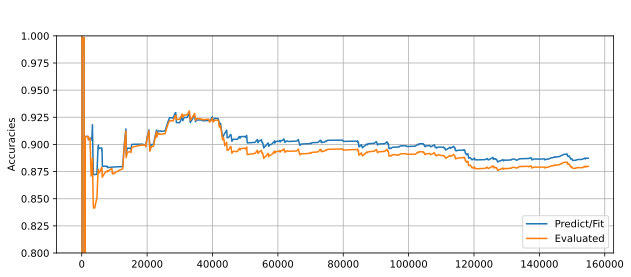

In [42]:
plot_acc(accuraciese, accuracieseD, '', '')

In [ ]:
dr = drift_reg()
lastfile = -1
for i, (ifile, er, y) in enumerate(zip(ifiles, np.not_equal(yse, y_predse), yse)):
    if ifile != lastfile:
        lastfile = ifile
        drd = drift.EDDM(warm_start=30, alpha=0.7, beta=0.6)
        #drd = drift.DDM(warm_start=30, warning_threshold=2, drift_threshold=3)
        #drd = drift.HDDM_A(drift_confidence=0.001, warning_confidence=0.005, two_sided_test=False)
        #drd = drift.HDDM_W(drift_confidence=0.001, warning_confidence=0.005, lambda_val=0.05, two_sided_test=False)
        print_warning = True
        n = 0
    _ = drd.update(er)
    warn = change = False
    if drd.warning_detected and print_warning:
        warn = True
        print(f"Warning detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
        print_warning = False
    if drd.drift_detected:
        change = True
        print(f"Change detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
        print_warning = True
    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change)
    n += 1

res = dr.to_df()

In [32]:
res = dr.to_df()
res

,i,n,ifile,label,y,path,warn,change,origin,well
0,802,788,0,1,101,..\dataset\1\SIMULATED_00103.csv,False,True,S,NaN
1,3397,288,7,1,101,..\dataset\1\SIMULATED_00086.csv,False,True,S,NaN
2,3501,392,7,1,101,..\dataset\1\SIMULATED_00086.csv,True,False,S,NaN
3,5261,554,10,1,101,..\dataset\1\SIMULATED_00090.csv,False,True,S,NaN
4,6431,123,13,1,101,..\dataset\1\WELL-00001_20140124213136.csv,True,False,R,1.0
...,...,...,...,...,...,...,...,...,...,...
106,153582,688,350,1,1,..\dataset\1\SIMULATED_00021.csv,False,True,S,NaN
107,154072,417,351,1,101,..\dataset\1\SIMULATED_00012.csv,True,False,S,NaN
108,154084,429,351,1,101,..\dataset\1\SIMULATED_00012.csv,False,True,S,NaN
109,156043,307,354,1,101,..\dataset\1\SIMULATED_00074.csv,False,True,S,NaN


In [29]:
res.groupby(['origin', 'label', 'y', 'warn', 'change'])['path'].count()

origin  label  y    warn   change
D       1      0    False  True       5
               1    False  True       2
                    True   False      2
               101  False  True       8
                    True   False      8
R       0      0    False  True       6
                    True   False      1
        1      101  False  True       4
                    True   False      3
S       1      1    False  True      23
                    True   False      9
               101  False  True      51
                    True   False     16
Name: path, dtype: int64

In [28]:
res.groupby(['origin', 'label', 'y', 'warn', 'change'])['path'].count() /\
            res.groupby(['origin', 'label', 'y'])['path'].count() * 100

origin  label  y    warn   change
D       1      0    False  True      100.000000
               1    False  True       50.000000
                    True   False      50.000000
               101  False  True       50.000000
                    True   False      50.000000
R       0      0    False  True       85.714286
                    True   False      14.285714
        1      101  False  True       57.142857
                    True   False      42.857143
S       1      1    False  True       71.875000
                    True   False      28.125000
               101  False  True       76.119403
                    True   False      23.880597
Name: path, dtype: float64

In [176]:
res.groupby(['origin', 'warn', 'change'])['path'].count() /\
            res.groupby(['origin'])['path'].count() * 100

origin  warn   change
R       False  True      83.333333
        True   False     16.666667
Name: path, dtype: float64

In [177]:
res.groupby(['label', 'warn', 'change'])['path'].count() /\
            res.groupby(['label'])['path'].count() * 100

label  warn   change
0      False  True      100.0
2      False  True       50.0
       True   False      50.0
Name: path, dtype: float64

In [178]:
res.groupby(['y', 'warn', 'change'])['path'].count() /\
            res.groupby(['y'])['path'].count() * 100

y    warn   change
0    False  True      100.0
102  False  True       50.0
     True   False      50.0
Name: path, dtype: float64

In [179]:
res.groupby(['well', 'warn', 'change'])['path'].count() /\
            res.groupby(['well'])['path'].count() * 100

well  warn   change
3     False  True      100.000000
5     False  True      100.000000
8     False  True      100.000000
11    False  True       33.333333
      True   False      66.666667
13    False  True      100.000000
Name: path, dtype: float64